# Load trained StyleGAN model

In [ ]:
import numpy as np
import collections
import tensorflow as tf
import pickle
import dnnlib.tflib as tflib

tflib.init_tf()
f = open('karras2019stylegan-ffhq-1024x1024.pkl', 'rb')
_G, _D, _Gs = pickle.load(f)
print('Gs ready')

# Load best weights (Gs) into memory
sess = tf.get_default_session()    
all_weights = collections.OrderedDict()
with sess.as_default():  
    for i, (key, weight_tensor) in enumerate(_Gs.vars.items()):        
        all_weights[key] = weight_tensor.eval()
        print('.', end='')
print(' ({}) weights found. '.format(len(all_weights)))

# Save best weights (Gs) to disk

In [ ]:
pickle.dump(all_weights, open( 'gs_weights.pkl', 'wb' ) )
print('Saved original StyleGAN weights to disk.')

# Create our `tf.kears.Model` version of StyleGAN

In [ ]:
import numpy as np
from stylegan import StyleGAN_G

model = StyleGAN_G()

# Load best StyleGAN weights (Gs) from disk

In [ ]:
import pickle
all_weights = pickle.load(open('gs_weights.pkl', 'rb'))
print('Weights loaded to memory.')

from stylegan import copy_weights_to_keras_model
copy_weights_to_keras_model(model.model_mapping, all_weights)
copy_weights_to_keras_model(model.model_synthesis, all_weights)

(1, 1024, 1024, 3) 0.0 1.0


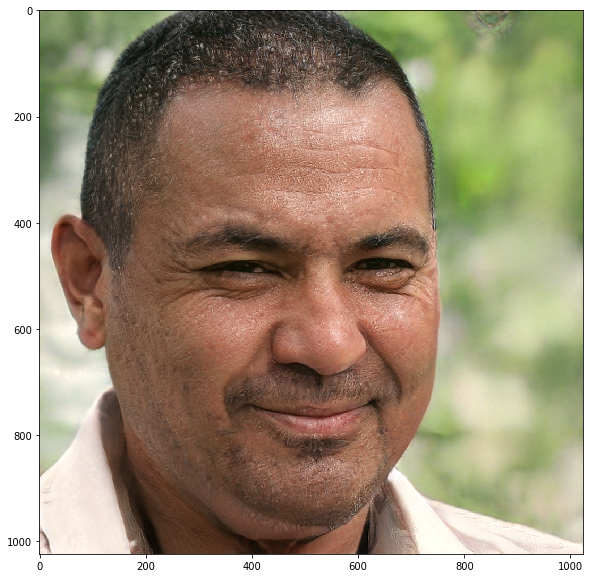

In [6]:
%matplotlib inline
y = model.generate_sample(is_visualize=True)

# Test saving and loading from and to `tf.keras.Model` weights

(1, 1024, 1024, 3) 0.0 1.0


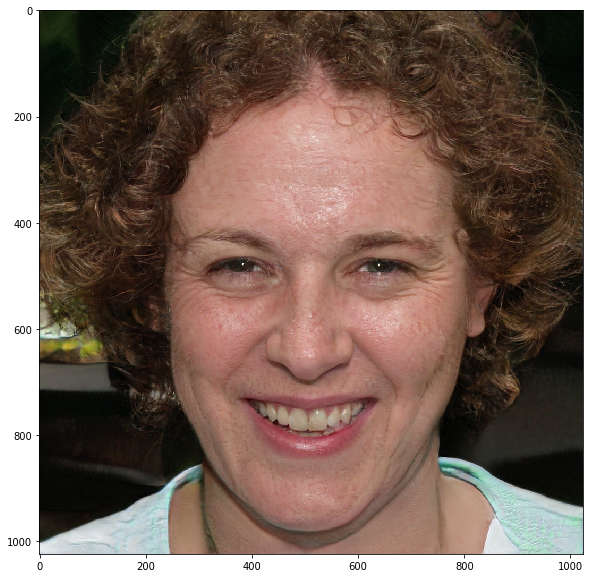

In [8]:
model.save_weights('stylegan.h5')
model.load_weights('stylegan.h5')

y2 = model.generate_sample(3, is_visualize=True)

# Test discriminator (D)

In [ ]:
from stylegan import StyleGAN_D

# Load best weights (D) into memory
sess = tf.get_default_session()    
all_weights = collections.OrderedDict()
with sess.as_default():  
    for i, (key, weight_tensor) in enumerate(_D.vars.items()):        
        all_weights[key] = weight_tensor.eval()
        print('.', end='')
print(' ({}) weights found. '.format(len(all_weights)))

d_model = StyleGAN_D()
copy_weights_to_keras_model(d_model.model, all_weights)

In [15]:
d_model.predict( y.transpose([0, 3, 1, 2]) )

array([[-6.7732077]], dtype=float32)

# (Optional) visualize the model graph

In [ ]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

tf.reset_default_graph()
model = StyleGAN_G()

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:900px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1400px;height:900px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph().as_graph_def())